# Nerual network with ANS

Before executing the code below, following pre-requisites (in addition to the ones required for the evaluator package) are required.

In [17]:
%pip install pandas matplotlib numpy scikit-learn 
%pip install ../dist/compression_evaluation-0.1.0-py3-none-any.whl --force-reinstall

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing c:\users\dell\documents\project\research\code\compression-algorithm-eval\dist\compression_evaluation-0.1.0-py3-none-any.whl
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl.metadata (23 kB)
Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)
Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl (12.8 MB)
Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl (247 kB)
  Attempting uninstall: psutil
    Found existing installation: psutil 7.1.0
    Uninstalling psutil-7.1.0:
      Successfully uninstalled psutil-7.1.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3
  Attempting uninstall: memory-profiler
    Found existing installation: memory-profiler 0.61.0
    Uninstalling memory-profiler-0.61.0:
      Successfully uninstalled memor

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import compression_evaluation.methods as util_methods
from compression_evaluation.classes import UniformQuantizer, SimpleFrequencyTable
from compression_evaluation.types import RegressorEnvelop
from compression_evaluation.methods import largest_remainder_quantize
from compression_evaluation.classes import ANSCoder, StaticResidualRegressor, PCEncoder, PCDecoder
from compression_evaluation.evaluator import Evaluator

## Import datasets

Three datasets were used in this evaluation, all extracted from the Ariviyal Nagar weather station. Datasets accessible [here](https://www.ariviyalnagarweatherstation.org/Data.html).

From the dataset, three columns were used for this evaluation, which were extracted and isolated into seperate files for convenience. They were,
1. Solar Radition - A dataseries with a multi-modal (bimodal) distribution
2. Water Content - A dataseries with sudden rises and falls with mostly gradual fade
3. Air Temperature - A dataseries with mostly deterministic patterns with slight noise

In [19]:
air_temperature_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Air_Temperature.csv')

extract dataseries,

In [20]:
air_temperature_column = air_temperature_df['Air Temperature']

## Inspect datasets

Basic data pre-processing

In [21]:
def print_invalids_count():
    print("Air Temperature NaNs:", air_temperature_column.isna().sum())

    print("Air Temperature Nulls:", air_temperature_column.isnull().sum())

def fill_with_mean(series):
    # Find indices where value is NaN or null
    nan_indices = series[series.isna() | series.isnull()].index
    for idx in nan_indices:
        prev_idx = idx - 1
        next_idx = idx + 1
        # Find previous non-null value
        while prev_idx >= 0 and (pd.isna(series.iloc[prev_idx]) or pd.isnull(series.iloc[prev_idx])):
            prev_idx -= 1
        # Find next non-null value
        while next_idx < len(series) and (pd.isna(series.iloc[next_idx]) or pd.isnull(series.iloc[next_idx])):
            next_idx += 1
        # If both indices are valid, fill with their mean
        if prev_idx >= 0 and next_idx < len(series):
            mean_val = (series.iloc[prev_idx] + series.iloc[next_idx]) / 2
            series.iloc[idx] = mean_val
    return series

# Before filling
print("Before cleanup: ")
print_invalids_count()

air_temperature_column = fill_with_mean(air_temperature_column)

# After filling
print("\nAfter cleanup: ")
print_invalids_count()

Before cleanup: 
Air Temperature NaNs: 0
Air Temperature Nulls: 0

After cleanup: 
Air Temperature NaNs: 0
Air Temperature Nulls: 0


Plot each dataseries to observe their continuity

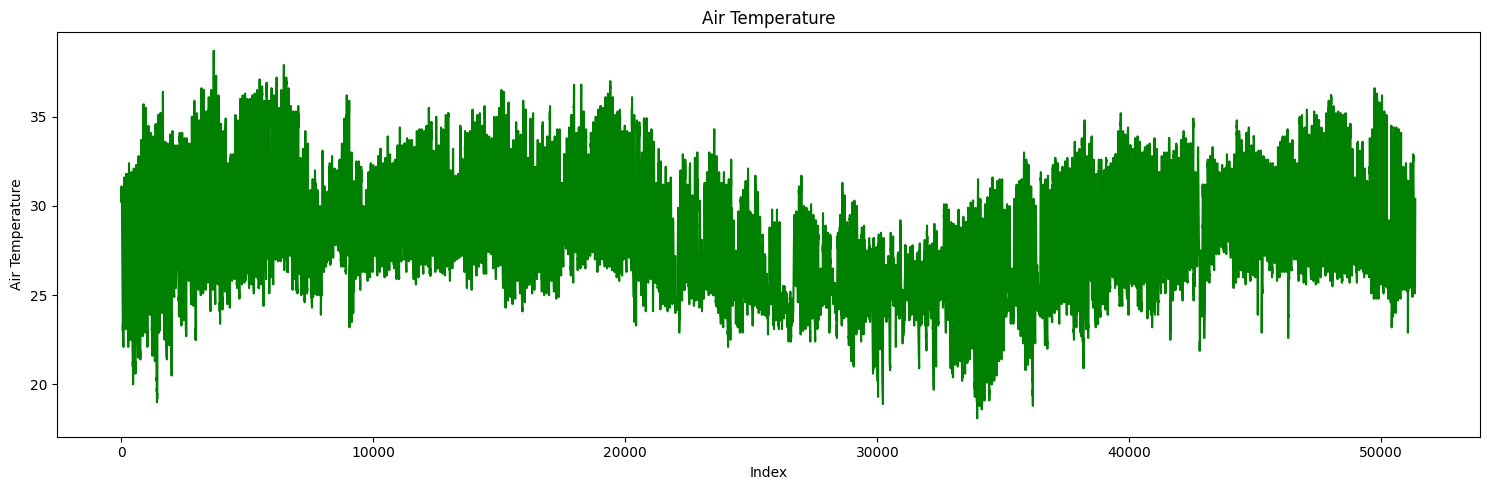

In [22]:
fig = plt.figure(figsize=(15, 5))

plt.plot(air_temperature_column, color='g')
plt.title('Air Temperature')
plt.ylabel('Air Temperature')
plt.xlabel('Index')

plt.tight_layout()
plt.show()

Plot and observe the dataset's value distribution

Completed Calculation of Air Temperature Histogram...


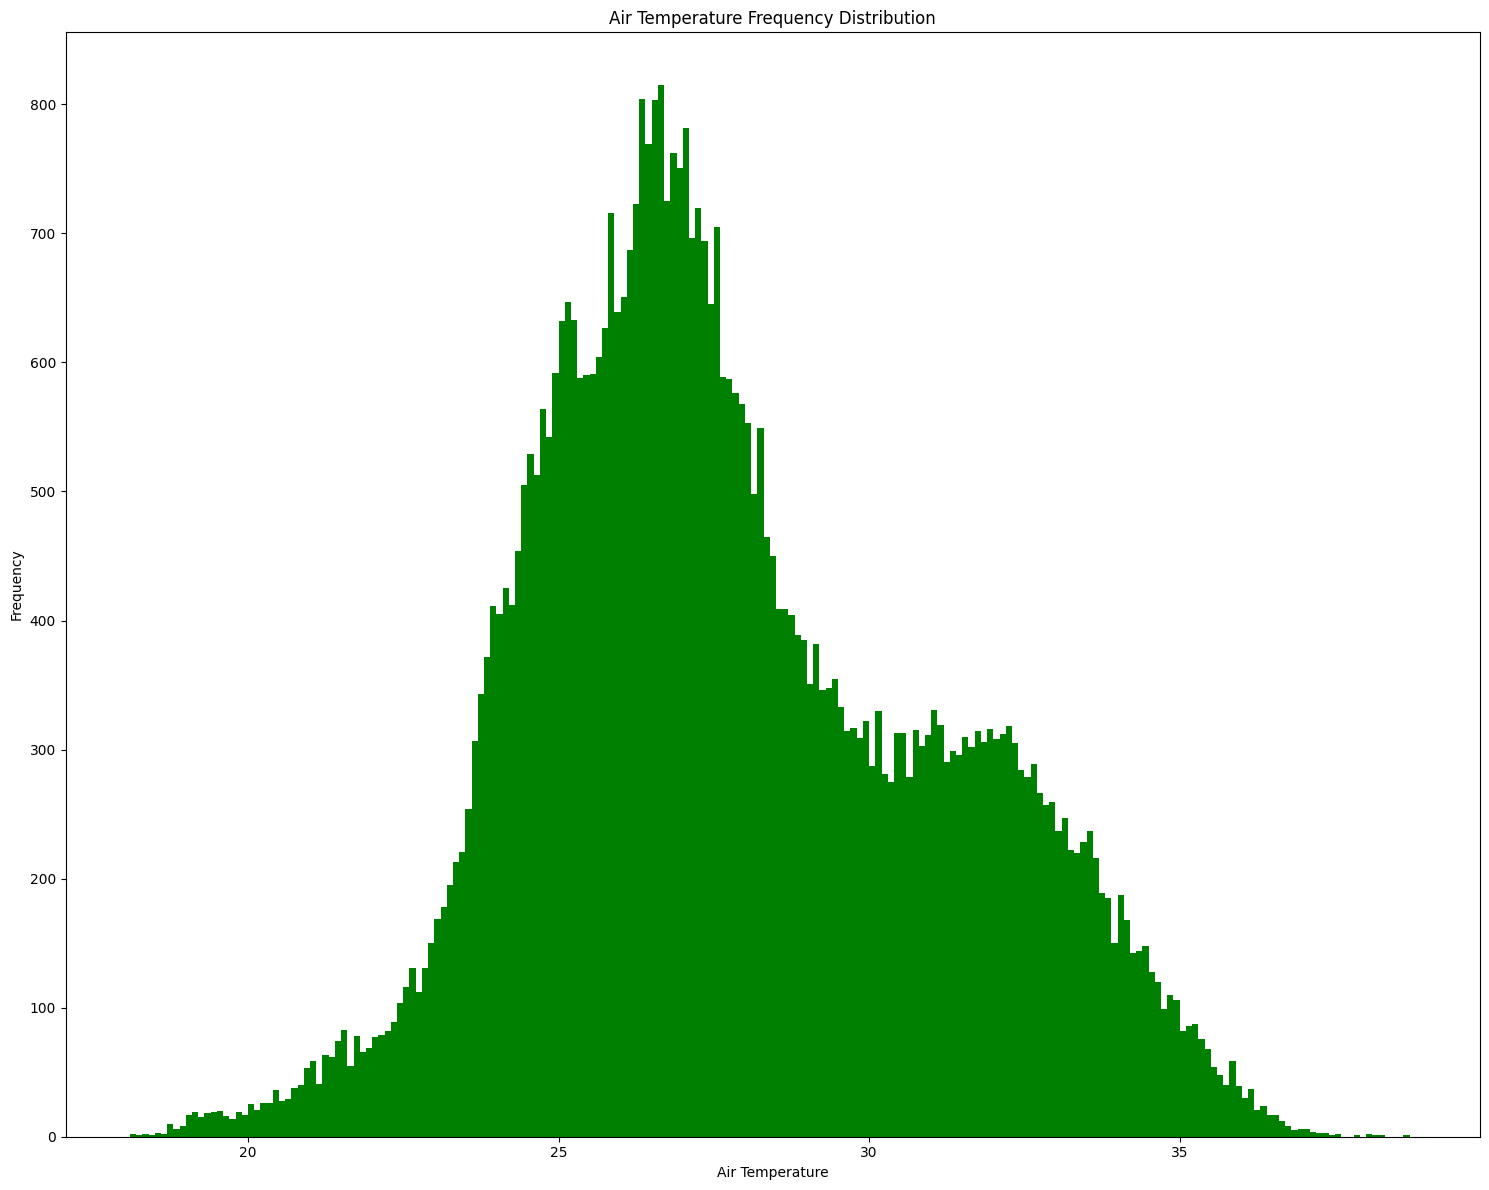

In [23]:
fig = plt.figure(figsize=(15, 12))

# Bin sizes
air_bin_size = 0.1

# Air Temperature
air_min, air_max = air_temperature_column.min(), air_temperature_column.max()
air_bins = np.arange(air_min, air_max + air_bin_size, air_bin_size)
plt.hist(air_temperature_column, bins=air_bins, color='g')
plt.title('Air Temperature Frequency Distribution')
plt.ylabel('Frequency')
plt.xlabel('Air Temperature')

print("Completed Calculation of Air Temperature Histogram...")

plt.tight_layout()
plt.show()


In [24]:
# Split training and testing sets

# Air temperature
air_temperature_training = air_temperature_column[:(len(air_temperature_column) * 9) // 10]
air_temperature_testing = air_temperature_column[(len(air_temperature_column) * 9) // 10:]


## Train Linear Predictor for optimum residuals

### For air temperature dataseries

Train linear regressors on air temperature dataset.

In [25]:
# split training dataeet into training and validating datasets
air_temperature_validating = air_temperature_training[(len(air_temperature_column) * 7) // 9:]
air_temperature_training = air_temperature_training[:(len(air_temperature_column) * 7) // 9]

In [ ]:
# Prepare time series data 
X_train_8_3, y_train_8_3 = util_methods.build_time_series_dataset(air_temperature_training, 8, 3) 
X_valid_8_3, y_valid_8_3 = util_methods.build_time_series_dataset(air_temperature_validating, 8, 3, shuffle=False)

class SimpleNN:
    """
    Neural network with one hidden layer (ReLU) for regression.
    Input -> Hidden -> Output
    """
    def __init__(self, input_size, hidden_size, output_size, lr=0.01, seed=42):
        np.random.seed(seed)
        self.lr = lr
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros(output_size)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        self.X = X
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        return self.Z2

    def backward(self, y, output):
        m = y.shape[0]
        dZ2 = (output - y) / m  
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = self.X.T @ dZ1
        db1 = np.sum(dZ1, axis=0)

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def train(self, X, y, epochs, print_every=50):
        for epoch in range(epochs):
            output = self.forward(X)
            loss = np.mean((y - output) ** 2)
            self.backward(y, output)
            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward(X)

# Convert data to NumPy
X_train_8_3_np = X_train_8_3.astype(np.float64)
y_train_8_3_np = y_train_8_3.astype(np.float64)
X_valid_8_3_np = X_valid_8_3.astype(np.float64)
y_valid_8_3_np = y_valid_8_3.astype(np.float64)

# Initialize and train the network
model = SimpleNN(input_size=8, hidden_size=5, output_size=3, lr=0.01)
model.train(X_train_8_3_np, y_train_8_3_np, epochs=50, print_every=50)

# Prediction
y_train_8_3_pred = model.predict(X_train_8_3_np)
y_valid_8_3_pred = model.predict(X_valid_8_3_np)

# Compute residuals
residuals_8_3_train = np.round(y_train_8_3_np - y_train_8_3_pred, 1)
residuals_8_3_valid = np.round(y_valid_8_3_np - y_valid_8_3_pred, 1)

# Compute MSE
mse_train = np.mean(residuals_8_3_train**2)
mse_valid = np.mean(residuals_8_3_valid**2)

print("MSE (train):", mse_train)
print("MSE (validation):", mse_valid)

Epoch 50/50, Loss: 1061.6961
MSE (train): 1039.9982805769807
MSE (validation): 1098.3618257261412


## Generate and record residuals

Using the trained predictors, residuals are generated to identify their distribution. This is done by building the complete Encoder without its Quantizer.

You might observe the residuals taking the form of laplace distributions.

### For air temperature dataseries

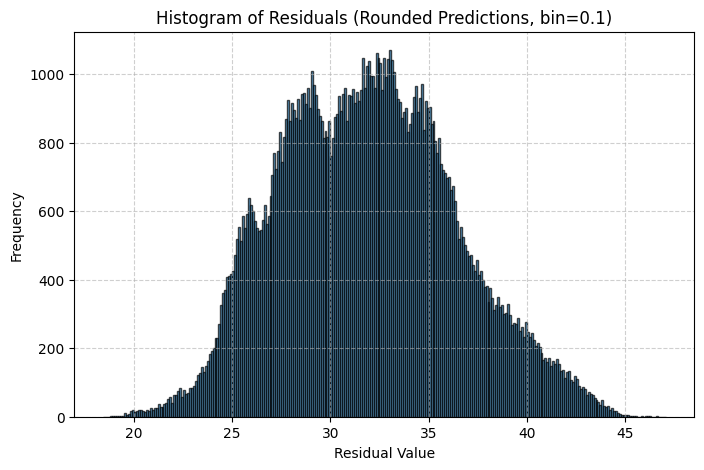

In [27]:
# generate bins to fit residuals (5 bin padding on either sides)
air_8_3_bins = np.arange(residuals_8_3_train.min() - 5 * air_bin_size, residuals_8_3_train.max() + 5 * air_bin_size, air_bin_size)

# get counts and bin edges
air_8_3_counts, air_8_3_bin_edges = np.histogram(residuals_8_3_train, bins=air_8_3_bins)
air_8_3_bin_centers = (air_8_3_bin_edges[:-1] + air_8_3_bin_edges[1:]) / 2

# plot histogram (reusing same bins)
plt.figure(figsize=(8, 5))
plt.bar(air_8_3_bin_centers, air_8_3_counts, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals (Rounded Predictions, bin=0.1)")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Fit frequency tables for residuals

### For air temperature dataseries

In [28]:
# input_dim = 8
# pad frequencies (given ANS considers symbols with 0 occurances are impossible)
air_8_3_padded_counts = air_8_3_counts + 1

# fit quantizer
air_8_3_quantizer = UniformQuantizer(air_bin_size, len(air_8_3_bins), air_8_3_bin_edges[1], True)

# map bin centers to symbols
air_8_3_symbols = [air_8_3_quantizer.value_to_symbol(res) for res in air_8_3_bin_centers]

## Build complete encoder-decoder pair

### For air temperature dataseries

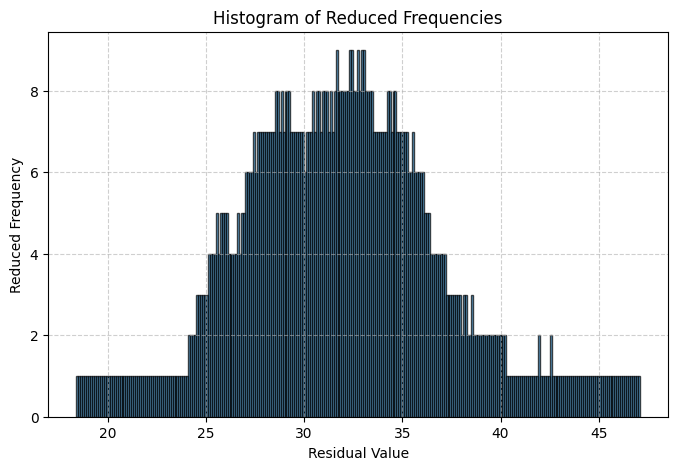

In [29]:
# Trim frequencies to total sum
air_8_3_counts_trimmed = largest_remainder_quantize(air_8_3_counts.tolist(), 1024)

# Plot reduced counts to observe shape
plt.figure(figsize=(8, 5))
plt.bar(air_8_3_bin_centers, air_8_3_counts_trimmed, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Reduced Frequencies")
plt.xlabel("Residual Value")
plt.ylabel("Reduced Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Build a simple frequency table for ANS
air_8_3_freq_table = SimpleFrequencyTable(air_8_3_counts_trimmed)

# Build ANS coder
air_8_3_ans = ANSCoder(air_8_3_freq_table, air_8_3_quantizer)

# Build a RegressorEnvelop 
class NNRegressorEnvelop(RegressorEnvelop):
    """
    Wrapper for the trained SimpleNN model to match RegressorEnvelop interface.
    """
    def __init__(self, model, input_size=8):
        self.model = model
        self.input_size = input_size

    def predict(self, n, input_window):
        """
        n: number of steps to predict
        input_window: current input window of shape (input_size,)
        Returns: predicted values (length n)
        """
        input_window = np.asarray(input_window).reshape(1, -1)  
        output = self.model.predict(input_window).reshape(-1)
        return output[:n]

# Build static residual regressors with trained NN
air_8_enveloped_regressor = NNRegressorEnvelop(model, input_size=8)
air_8_encoder_residual_regressor = StaticResidualRegressor(air_8_enveloped_regressor, 8)
air_8_decoder_residual_regressor = StaticResidualRegressor(air_8_enveloped_regressor, 8)

# Initialize sliding windows (length = input size)
air_8_encoder_residual_regressor._window = air_temperature_testing[0:8].to_numpy()
air_8_decoder_residual_regressor._window = air_temperature_testing[0:8].to_numpy()

# Build PC (predictive coding) encoder and decoder
air_8_nn_encoder = PCEncoder(air_8_encoder_residual_regressor,air_8_3_ans,air_8_3_quantizer,3)


air_8_nn_decoder = PCDecoder(air_8_decoder_residual_regressor, air_8_3_ans, air_8_3_quantizer, 3)


## Evaluate encoder-decoder pair

### For air temperature dataseries

In [30]:
# input dim = 8
# Sample encoding/decoding
encoded = air_8_nn_encoder.encode(air_temperature_testing[:50].to_numpy())
decoded = air_8_nn_decoder.decode(encoded)

print("Original series:\t", air_temperature_testing[:50].to_list())
print("Reconstructed series:\t", np.round(np.array(decoded), 1).tolist())

air_8_evaluator = Evaluator(air_8_nn_encoder, air_8_nn_decoder)

# evaluate with test dataset
print("\nEvaluation Metrics:")
air_8_evaluator.evaluate(air_temperature_testing[5:].to_numpy())

Original series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]
Reconstructed series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]

Evaluation Metrics:


{'encode_time_sec': 1.5053869000003033,
 'encode_mem_mb': 197.4609375,
 'decode_time_sec': 1.213726800000586,
 'decode_mem_mb': 197.48046875,
 'compression_ratio': 8.418375717801476,
 'bits_per_symbol': 7.6024166829078155,
 'mse': np.float64(0.0006386621566648778),
 'snr_db': np.float64(61.23250499851834)}